<a href="https://colab.research.google.com/github/Sunil260/CNN-Face-Emotion-Analysis/blob/main/faceEmotionalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Emotional Analysis To Produce a Song/Playlist/Genre Suggestion
**Plan To Use PreTreained model then freeze the base of the model and train and additional 2 layers for emotional analysis. **


In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download "jonathanoheix/face-expression-recognition-dataset"

#folder_path = '../input/face-expression-recognition-dataset/images/'

face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip "face-expression-recognition-dataset"


Archive:  face-expression-recognition-dataset.zip
replace images/images/train/angry/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
keras = tf.keras
layers = keras.layers
models = keras.models


In [24]:
!ls
data_dir = "./images/train"
validation_dir = "./images/validation"

batch_size = 64
img_size = 48
!pwd

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  shuffle=True,
  batch_size=batch_size,
  image_size=(img_size, img_size))

#datasets loaded completed



face-expression-recognition-dataset.zip  kaggle.json  saved_model
images					 sample_data
/content
Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Found 7066 files belonging to 7 classes.


In [25]:
CATEGORIES = ['angry','disgust','fear','happy','neutral','sad','suprise']

train_labels = train_ds.class_names
validation_labels = validation_ds.class_names



In [ ]:
#plotting the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_labels[labels[i]])
    plt.axis("off")

In [27]:
#Check the tensor shapes
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(64, 48, 48, 3)
(64,)


In [28]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#Build the model
num_classes = 7
model = models.Sequential()

#First layer to normalize the RGB chanels 
model.add(layers.Rescaling(1./255))

model.add(data_augmentation)

#3 layer stack for convlutional block

model.add(layers.Conv2D(64, 3, padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, 3, padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, padding='same',activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.20))

model.add(layers.Conv2D(256, 3, padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.20))

model.add(layers.Conv2D(512, 3, padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.20))

#Flatten for dense layer
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.20, input_shape=(3,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.20))
model.add(layers.Dense(num_classes,activation = 'softmax'))


In [29]:
#Training the model
model.compile(
    optimizer= 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy']
)



In [31]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)


Epoch 1/100
361/361 [==============================] - 13s 35ms/step - loss: 1.7721 - accuracy: 0.2718 - val_loss: 1.8453 - val_accuracy: 0.2597
Epoch 2/100
361/361 [==============================] - 12s 32ms/step - loss: 1.7454 - accuracy: 0.2900 - val_loss: 1.8081 - val_accuracy: 0.2564
Epoch 3/100
361/361 [==============================] - 12s 33ms/step - loss: 1.7272 - accuracy: 0.2990 - val_loss: 1.7138 - val_accuracy: 0.2997
Epoch 4/100
361/361 [==============================] - 12s 33ms/step - loss: 1.6937 - accuracy: 0.3175 - val_loss: 1.8143 - val_accuracy: 0.2223
Epoch 5/100
361/361 [==============================] - 12s 33ms/step - loss: 1.6585 - accuracy: 0.3399 - val_loss: 1.6600 - val_accuracy: 0.3343
Epoch 6/100
361/361 [==============================] - 12s 33ms/step - loss: 1.6433 - accuracy: 0.3485 - val_loss: 1.5467 - val_accuracy: 0.3924
Epoch 7/100
361/361 [==============================] - 12s 33ms/step - loss: 1.6077 - accuracy: 0.3644 - val_loss: 1.5756 - val_ac

In [33]:
model.summary()
# Save the entire model as a SavedModel.
!mkdir -p saved_model

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('../face_model_highePoch.h5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 sequential_6 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_10 (Bat  (None, 24, 24, 128)      512       
 chNormalization)                                     

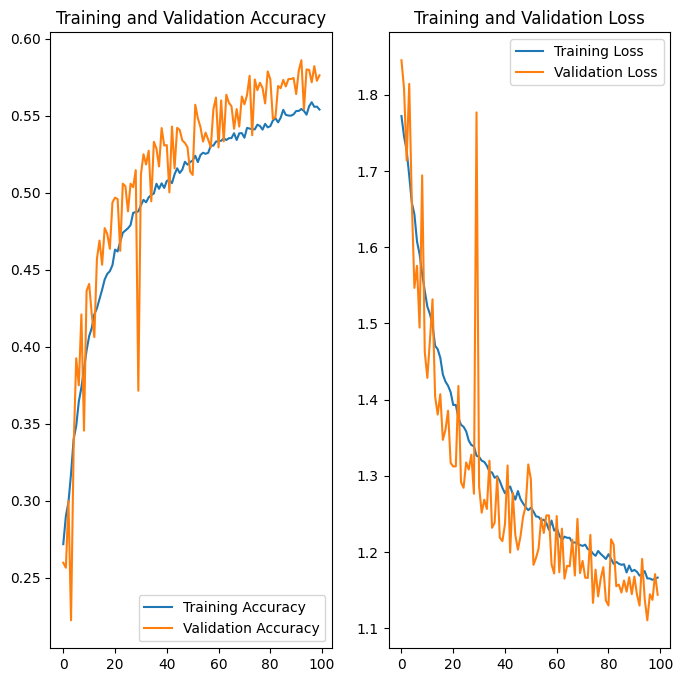

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()